# Code behind "Adsorption of PFASSs in the Vadose Zone and Implications for Long-Term Groundwater Contamination"

The code below generates figures 1-4 and 6 in the main text of the publication. 

In [1]:
import os
import numpy as np
import pandas as pd

#additional matplotlib functionality
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as mtick
from labellines import labelLine, labelLines
rc('font',**{'family':'serif','serif':['Arial']})
plt.rcParams['font.size'] = 16
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec

In [2]:
#set the DPI for all plots
dpi = 100

## Functions (see refs to paper)

In [3]:
#equation S1
def conc_star(conc_pfas, anion, cation): 
    '''
    Arguments
    conc_pfas: concentration of PFAS species originally in mol/m3
    anion: counter anion concentration
    cation: counter cation concentraton
    
    Returns
    conc_star: activity corrected concentration of PFAA in solution with variable salt concentration (if applicable)
    '''
    I = 0.5*(conc_pfas + anion + cation) # - Ionic strength calculations are in molarity **convert units prior!
    logy = (0.507*np.sqrt(I))/(1+np.sqrt(I))+0.1*I #activity
    y = 10**(-logy)
    conc_star = np.sqrt((y*(conc_pfas+cation))*(y*conc_pfas))*1000 #C* in mol/m3
    return conc_star

#equations 5, 7 and 8
def langmuir(wtr, T_max, a, conc_star, conc):
    '''
    Air-water adsorption (Kaw) calculation using a Langmuir-Skowski adsorption model
    *For a more detailed explination see Equation X in associated publication
    
    Arguments
    wtr: surface tension of water (or solvent) [mN/m]
    T_max: maximum surface excess [UNITS]
    a: fitting parameter
    conc_star: activity corrected PFAA concentration in solution
    conc: non-activity corrected PFAA concentration
    
    Returns
    sft: estimated surface tension in mN/m
    kaw: air-water adsorption coefficent in meters
    '''
    sft = wtr - (8310*294)*T_max*np.log(1 + a*conc_star) 
    surf_ex = (T_max*a*conc_star)/(1+ a*conc_star)
    kaw = surf_ex/conc
    return sft, kaw

#equations 4, 6, and 8
def freundlich(wtr, k, n, conc_star, conc):
    '''
    Air-water adsorption (Kaw) calculation using a Freundlich adsorption model
    For a more detailed explination see Equation X in associated publication
    
    Arguments
    wtr: surface tension of water (or solvent) [mN/m]
    k: fitting parameter
    n: fitting parameter
    conc_star: activity corrected PFAA concentration in solution
    conc: non-activity corrected PFAA concentration
    
    Returns
    sft: estimated surface tension in mN/m
    kaw: air-water adsorption coefficent in meters
    '''
    sft = wtr - (8310*294)*k*((conc_star**n)/n)
    surf_ex = k*conc_star**n
    kaw = surf_ex/conc
    return sft, kaw

#equation 9
def Sw_func(a, n, Pc, Sr):
    '''
    Function to produce capillary pressure curves from pressure
    *For more detail see equation 9 in assocaited publication
    
    Arguments
    a: entry pressure (inverse?)
    n: pore-size distribution
    Pc: range of pressure values
    Sr: residual saturation
    
    Returns
    Sw: water saturation profile for a given range of capillary pressure values (Pc) and fitting parameters (a, n, Sr)
    '''
    m = 1 - (1/n)
    Sw = Sr+(1-Sr)*(1+(a*Pc)**n)**-m
    return Sw

#rearranging equation 9 for Pc instead of Sw
def Pc_func(a, m, Sw, Sr):
    '''
    Function to produce capillary pressure curves from water content (water saturation 0 - 1)
    *For more detail see equation X in assocaited publication
    
    Arguments
    a: entry pressure (inverse?)
    m: fitting parameter, related to the pore-size distribution
    Sw: range of water saturation values (0 - 1)
    Sr: residual saturation
    
    Returns
    Pc: capillary pressure profile for a given range of capillary pressure values (Pc) and fitting parameters (a, m, and Sr)
    '''
    Seff = (Sw - Sr)/(1 - Sr)
    #n = 1 / (1-m)
    Pc = (1/a)*(Seff**(-1/m)-1)**(1-m)
    return Pc

#equations 1, 9, and 10
def vadoseRetaration_profile_func(av, nv, Sr, Pc, s, U, phi, rhob, kaw, koc, foc, km):
    '''
    Generates 1-D vadose zone adsorption profile
    
    Arguments
    av:  Van Genuchten fitting parameter "a" [1/kPa]
    nv:  Van Genuchten fitting parameter "n" related to the pore-size distribution
    Sr:  residual water saturation
    Pc:  capillary pressure [kPa]
    s:   soil specific surface area [1/cm]
    U:   uniformity coeff defined by d60/d10
    phi: porosity of soil
    rhob: bulk density of soil [kg/L or g/cm3]
    kaw: PFAS air-water partitioning coeff [cm]
    koc: PFAS octanol-water paritioning coeff [L/kg]
    foc: fraction of organic carbon in soil
    km:  PFAS partitioning coeff to mineral phases (if known/estimated) [L/kg]
    
    Returns
    R_total:   total PFAS retardation
    Raw_total: total PFAS retardation associated with the air-water interface
    Rsp_total: total PFAS retardation associated with the solid-phase
    '''
    
    #saturation from Van Genucten (1980)
    #from 10.2136/sssaj1980.03615995004400050002x
    mv = 1 - (1/nv)   
    Sw = Sr+(1-Sr)*(1+(av*Pc)**nv)**-mv #change with thermo appraoch 
    
    #Awi calulations
    a = 14.3*np.log(U)+3.72
    m = 1.2 # currently only valid for U>3.5
    # m = -0.098*U+1.53 #for U<3.5
    n = 1/(2-m)
    Aia = s*(1+(a*(Sr+(1-Sr)*(Sw))**n))**-m  
    R_aw = kaw * Aia/(Sw*phi)
    Raw_total = 1 + R_aw
    #solid-phase
    kd_oc = koc*foc
    R_oc = (kd_oc *rhob/(Sw*phi)) #OC component
    R_m = (km *rhob/(Sw*phi)) #mineral component
    R_sp = R_m + R_oc
    Rsp_total = 1+ R_sp
    R_total = 1 + R_aw + R_sp #combined retardation
    
    return R_total, Raw_total, Rsp_total

#For 2D plots - calculate Saturation surface from av and Pc range --> 
#equations 1, 9, and 10
def vadoseRetaration_2Dprofile_func(av, nv, Sr, Pc_kpa, s, U, phi, rhob, kaw, koc, foc, km):
    '''
    Generates 2-D profile (Height above water-table vs Water saturation) of PFAS adsorption
    in the vadose zone for a fixed "nv" (van Genuchten pore-size distribution parameter) and
    PFAA concentration
    
    Arguments
    av (vector spanning the range of av values):  Van Genuchten fitting parameter "a" [1/kPa]
    nv (float):  Van Genuchten fitting parameter "n" related to the pore-size distribution
    Sr (float):  residual water saturation
    Pc (vector across the depth of the vadose zone):  capillary pressure [kPa]
    s (float):   soil specific surface area [1/cm]
    U (float):   uniformity coeff defined by d60/d10
    phi (float): porosity of soil
    rhob (float): bulk density of soil [kg/L or g/cm3]
    kaw (float): PFAS air-water partitioning coeff [cm]
    koc (float): PFAS octanol-water paritioning coeff [L/kg]
    foc (float): fraction of organic carbon in soil
    km (float):  PFAS partitioning coeff to mineral phases (if known/estimated) [L/kg]
    
    Returns
    R_total (2-D numpy array):   total PFAS retardation
    Raw_total (2-D numpy array): total PFAS retardation associated with the air-water interface
    Rsp_total (2-D numpy array): total PFAS retardation associated with the solid-phase
    '''
    #saturation profile across values of av
    Sw = np.zeros([len(Pc_kpa), len(av)])
    for i in range(0, len(Pc_kpa)):
        for j in range(0, len(av)):
            mv = 1 - (1/nv)
            Sw[i,j] = Sr+(1-Sr)*(1+(av[j]*Pc_kpa[i])**nv)**-mv #change with thermo appraoch?
    #Awi parameters
    a = 14.3*np.log(U)+3.72
    m = 1.2# currently only valid for U>3.5
    # m = -0.098*U+1.53 #for U<3.5
    n = 1/(2-m)
    Aia = s*(1+(a*(Sr+(1-Sr)*(Sw))**n))**-m
    
    #Note: KAW and KD are derived from isotherms = specifc for a concentration
    R_aw = kaw * Aia/(Sw*phi)
    Raw_total = 1 + R_aw #total retarration associated with air-water interface
    kd_oc = koc*foc
    R_sp = (km *rhob/(Sw*phi)) + (kd_oc *rhob/(Sw*phi))
    Rsp_total = 1 + R_sp #total retardation associated with solid-phase sorption
    R_total = 1 + R_aw + R_sp #combine retardation effect.
    
    return R_total, Raw_total, Rsp_total

# PFAA measured data: 

### Define concentration ranges of interest

In [4]:
#Surface Tension measurements and predictions
#range of concentrations measured (mg/L)
conc = np.array([0.1, 0.5, 1, 5, 10, 50, 100]) #mg/L

#the addition of 0.1 M NaCl diluted the initial PFAA solutions by a factor of 0.1
conc_salt = np.array([0.09, 0.45, 0.9, 4.5, 9, 45, 90]) #mg/L

#converting mg/L concentration range into a continuous range of molarity for modeling purposes
conc_model = np.linspace(10**-8, 0.001, num = 500) #molarity

#concentrations from Brusseua et al (2018?)
bruss_conc = np.array([0.00000024, 0.00000115, 0.00000237, 0.00001136, 0.00002334, 0.00011681, 0.00023012, 0.00115173, 0.00226897, 0.00268812, 0.00601369, 0.01135572, 0.0223714])


#Modeling concentrations for estimating Retardation
conc_range = np.array([0.00001, 0.0001, 0.001, 0.002]) #mg/L -- 10ppt, 100ppt, 1ppb, 10 ppb
conc_text = np.array(['10 ppt', '100 ppt', '1 ppb', '2 ppb'])
C = 2 #index concentration of interest

# PFOA calculations

In [5]:
pfoa_mw = 438200 #mg/mol

### Ultrapure water

In [6]:
#Ultrapure water data======================================================================================================

#measured data
pfoa_conc_sft = np.multiply(conc, 1/pfoa_mw) #convert to molarity
pfoa_meas = np.array([72.599, 72.552, 72.672, 72.482, 71.724, 70.507, 66.834]) #surface tension in mN/m

#langmuir fitting Parameters
pfoa_T_max = 6.92*10**-6
pfoa_a = 1.79

#Freundlich fitting Parameters
pfoa_k = 9.5E-06
pfoa_n = 0.962

#Surface Tension and Kaw Predictions=======================================================================================

#modeled data - langmuir
pfoa_cstar_model = conc_star(conc_model, 0, 0)
pfoa_sft_l, pfoa_kaw_l = langmuir(72.8, pfoa_T_max, pfoa_a, pfoa_cstar_model, conc_model*1000)
#modeled data - freundlich
pfoa_sft_f, pfoa_kaw_f = freundlich(72.8, pfoa_k, pfoa_n, pfoa_cstar_model, conc_model*1000)

In [7]:
#Models for Retardation Profiles at concentration C
pfoa_conc = np.multiply(conc_range, 1000/pfoa_mw) #mol/m3
pfoa_star = conc_star(pfoa_conc/1000, 0, 0)

#kaw estimate
pfoa_se, pfoa_kaw = langmuir(72.8, pfoa_T_max, pfoa_a, pfoa_star[C], pfoa_conc[C])
pfoa_kaw = 100*pfoa_kaw #cm

### 0.1 M NaCl

In [8]:
#PFOA in NaCl ============================================================================
pfoa_nacl_conc_sft = np.multiply([90, 45, 9, 4.5, 0.45, 0.09], 1/pfoa_mw)
pfoa_bruss_conc_sft = np.array([0.00000024, 0.00000115, 0.00000237, 0.00001136, 0.00002334, 0.00011681, 0.00023012, 0.00115173, 0.00226897, 0.00268812, 0.00601369, 0.01135572, 0.0223714])
pfoa_nacl_meas = np.array([57.383, 61.458, 67.885, 69.988, 70.023, 72.972])
pfoa_bruss_meas = np.array([71.19, 70.595, 70.298, 67.917, 66.131, 59.881, 56.012, 44.702, 38.006, 34.137, 29.97, 22.53, 21.935])

#Langmuir fitting parameters
pfoa_nacl_T_max = 3.08E-06
pfoa_nacl_a = 0.5

#freundlich fitting parameters
pfoa_nacl_k = 6.25E-07
pfoa_nacl_n = 0.400


pfoa_cstar_nacl_model = conc_star(conc_model, 0.1, 0.1)**2

#modeled data salt - langmuir
pfoa_nacl_sft_l, pfoa_nacl_kaw_l = langmuir(71.8, pfoa_nacl_T_max, pfoa_nacl_a, pfoa_cstar_nacl_model, conc_model*1000)

#modeled data -freundlich
pfoa_nacl_sft_f, pfoa_nacl_kaw_f = freundlich(72, pfoa_nacl_k, pfoa_nacl_n, pfoa_cstar_nacl_model, conc_model*1000)

In [9]:
#Models for Retardation Profiles at concentration C
pfoa_nacl_star = conc_star(pfoa_conc/1000, 100/1000, 100/1000)**2 #note, square of mean ionic activiy

pfoa_nacl_sft, pfoa_nacl_kaw = langmuir(71.8, pfoa_nacl_T_max, pfoa_nacl_a, pfoa_nacl_star[C], pfoa_conc[C])
pfoa_nacl_kaw = 100*pfoa_nacl_kaw #cm

# PFOS

In [10]:
pfos_mw = 538220 #mg/mol

### Ultrapure Water

In [11]:
#measured
pfos_conc_sft = np.multiply(conc, 1/pfos_mw)
pfos_meas = np.array([72.678, 72.682, 72.546, 72.06, 71.393, 68.904, 65.561])

#langmuir Parameters
pfos_T_max = 3.08E-06
pfos_a = 6.36

#freundlich parameters
pfos_k = 8.28E-06
pfos_n = 0.85

#modeled - langmuir
pfos_cstar_model = conc_star(conc_model, conc_model, 0)
pfos_sft_l, pfos_kaw_l = langmuir(72.9, pfos_T_max, pfos_a, pfos_cstar_model, conc_model*1000)

#modeled - freundlich
pfos_sft_f, pfos_kaw_f = freundlich(72.9, pfos_k, pfos_n, pfos_cstar_model, conc_model*1000)

In [12]:
#Retardation estimates at concentration C -- langmuir adsorption model
pfos_conc = np.multiply(conc_range, 1000/pfos_mw) #mol/m3
pfos_star = conc_star(pfos_conc/1000, 0, pfos_conc/1000)

#kaw estimate
pfos_sft, pfos_kaw = langmuir(72.9, pfos_T_max, pfos_a, pfos_star[C], pfos_conc[C])
pfos_kaw = 100*pfos_kaw #cm

### 0.1 M NaCl

In [13]:
#PFOS in nacl
pfos_nacl_conc_sft = np.multiply(conc_salt, 1/pfos_mw)
pfos_nacl_meas = np.array([72.562, 71.991, 70.006, 65.637, 60.659, 52.13, 51.248])

pfos_nacl_T_max = 2.64E-05
pfos_nacl_a = 0.20

pfos_nacl_k = 1.74E-06
pfos_nacl_n = 0.444

#modeled salt - langmuir
pfos_cstar_nacl_model = conc_star(conc_model, 0.1, 0.1)**2
pfos_nacl_sft_l, pfos_nacl_kaw_l = langmuir(73.08, pfos_nacl_T_max, pfos_nacl_a, pfos_cstar_nacl_model, conc_model*1000)

#modeled salt - freundlich
pfos_nacl_sft_f, pfos_nacl_kaw_f = freundlich(73.08, pfos_nacl_k, pfos_nacl_n, pfos_cstar_nacl_model, conc_model*1000)

In [14]:
#PFOS in 0.1M NaCl==========================================================================
pfos_nacl_star = conc_star(pfos_conc/1000, 100/1000, 100/1000)**2 #note, square of mean ionic activiy

pfos_nacl_sft, pfos_nacl_kaw = langmuir(73.08, pfos_nacl_T_max, pfos_nacl_a, pfos_nacl_star[C], pfos_conc[C])
pfos_nacl_kaw = 100*pfos_nacl_kaw #cm


# PFHxS

In [15]:
pfhxs_mw = 438200 #mg/mol

### Ultrapure water

In [16]:
#measured
pfhxs_conc_sft = np.multiply(conc, 1/pfhxs_mw)
pfhxs_meas = np.array([72.717, 72.543, 72.858, 72.497, 72.548, 71.916, 71.248])

#langmuir fitting parameters
pfhxs_T_max = 5.94E-07
pfhxs_a = 6.378

#freundlich fitting parameters
pfhxs_k = 1.60E-06
pfhxs_n = 0.866

#modeled - langmuir
pfhxs_cstar_model = conc_star(conc_model, conc_model, 0)
pfhxs_sft_l, pfhxs_kaw_l = langmuir(72.829, pfhxs_T_max, pfhxs_a, pfhxs_cstar_model, conc_model*1000)
#modeled - freundlich
pfhxs_sft_f, pfhxs_kaw_f = freundlich(72.829, pfhxs_k, pfhxs_n, pfhxs_cstar_model, conc_model*1000)

In [17]:
#Retardation estimate for concentration C
pfhxs_conc = np.multiply(conc_range, 1000/pfhxs_mw) #mol/m3
pfhxs_star = conc_star(pfhxs_conc/1000, 0, pfhxs_conc/1000)

#kaw estimate
pfhxs_sft, pfhxs_kaw = langmuir(72.829, pfhxs_T_max, pfhxs_a, pfhxs_star[C], pfhxs_conc[C])
pfhxs_kaw = 100*pfhxs_kaw #cm

### 0.1 M NaCl

In [18]:
#PFHxS nacl===================================================================================================
pfhxs_nacl_conc_sft = np.multiply(conc_salt, 1/pfhxs_mw)
pfhxs_nacl_meas = np.array([72.984, 72.55, 72.408, 71.014, 69.92, 65.711, 62.779])

#langmuir fitting parameters
pfhxs_nacl_T_max = 1.5*10**-6
pfhxs_nacl_a = 1.399

#freundlich fitting parameters
pfhxs_nacl_k = 5.04E-07
pfhxs_nacl_n = 0.479

#modeled - langmuir
pfhxs_cstar_nacl_model = conc_star(conc_model, 0.1, 0.1)**2
pfhxs_nacl_sft_l, pfhxs_nacl_kaw_l = langmuir(73.27, pfhxs_nacl_T_max, pfhxs_nacl_a, pfhxs_cstar_nacl_model, conc_model*1000)

#modeled - freundlich
pfhxs_nacl_sft_f, pfhxs_nacl_kaw_f = freundlich(73.27, pfhxs_nacl_k, pfhxs_nacl_n, pfhxs_cstar_nacl_model, conc_model*1000)

In [19]:
#Retardation estimate
pfhxs_nacl_star = conc_star(pfhxs_conc/1000, 100/1000, 100/1000)**2 #note, square of mean ionic activiy

pfhxs_nacl_sft, pfhxs_nacl_kaw = langmuir(73.27, pfhxs_nacl_T_max, pfhxs_nacl_a, pfhxs_nacl_star[C], pfhxs_conc[C])
pfhxs_nacl_kaw = 100*pfhxs_nacl_kaw #cm

# PFDA

In [20]:
pfda_mw = 514080 #mg/mol

### Ultrapure Water

In [21]:
#measured
pfda_conc_sft = np.multiply(conc, 1/pfda_mw)
pfda_meas = np.array([72.575, 72.366, 72.284, 71.591, 71.292, 57.084, 45.958])

#langmuir fitting params
pfda_T_max = 3.77*10**-5
pfda_a = 1.77

#freundlich fitting params
pfda_k = 5.35E-05
pfda_n = 0.962

#modeled - langmuir
pfda_cstar_model = conc_star(conc_model, 0, 0)
pfda_sft_l, pfda_kaw_l = langmuir(72.55, pfda_T_max, pfda_a, pfda_cstar_model, conc_model*1000)

#modeled - freundlich
pfda_sft_f, pfda_kaw_f = freundlich(72.55, pfda_k, pfda_n, pfda_cstar_model, conc_model*1000)

In [22]:
#Retardation estimate
pfda_conc = np.multiply(conc_range, 1000/pfda_mw) #mol/m3
pfda_star = conc_star(pfda_conc/1000, 0, 0)

pfda_sft, pfda_kaw = langmuir(72.55, pfda_T_max, pfda_a, pfda_star[C], pfda_conc[C])
pfda_kaw = 100*pfda_kaw #cm

### 0.1 M NaCl

In [23]:
#PFDA nacl 0.09, 0.45, 0.9, 4.5, 9, 45, 90
pfda_nacl_conc_sft = np.multiply(conc_salt, 1/pfda_mw)
pfda_nacl_meas = np.array([72.405, 71.769, 70.791, 57.155, 50.982, 30.946, 29.472])

#modeled
pfda_cstar_nacl_model = conc_star(conc_model, 0.1, 0.1)**2

#langmuir fitting parameters
pfda_nacl_T_max = 1.5*10**-5
pfda_nacl_a = 0.7

#freundlich fitting parameters
pfda_nacl_k = 4.14E-06
pfda_nacl_n =  0.512

#modeled - langmuir
pfda_nacl_sft_l, pfda_nacl_kaw_l = langmuir(73.28, pfda_nacl_T_max, pfda_nacl_a, pfda_cstar_nacl_model, conc_model*1000)
#modeled - freundlich
pfda_nacl_sft_f, pfda_nacl_kaw_f = freundlich(73.28, pfda_nacl_k, pfda_nacl_n, pfda_cstar_nacl_model, conc_model*1000)

In [24]:
#retardation estimate at concentration C
pfda_nacl_star = conc_star(pfda_conc/1000, 100/1000, 100/1000)**2 #note, square of mean ionic activiy

pfda_nacl_sft, pfda_nacl_kaw = langmuir(73.28, pfda_nacl_T_max, pfda_nacl_a, pfda_nacl_star[C], pfda_conc[C])
pfda_nacl_kaw = 100*pfda_nacl_kaw #cm

# Surface Tension Visualization

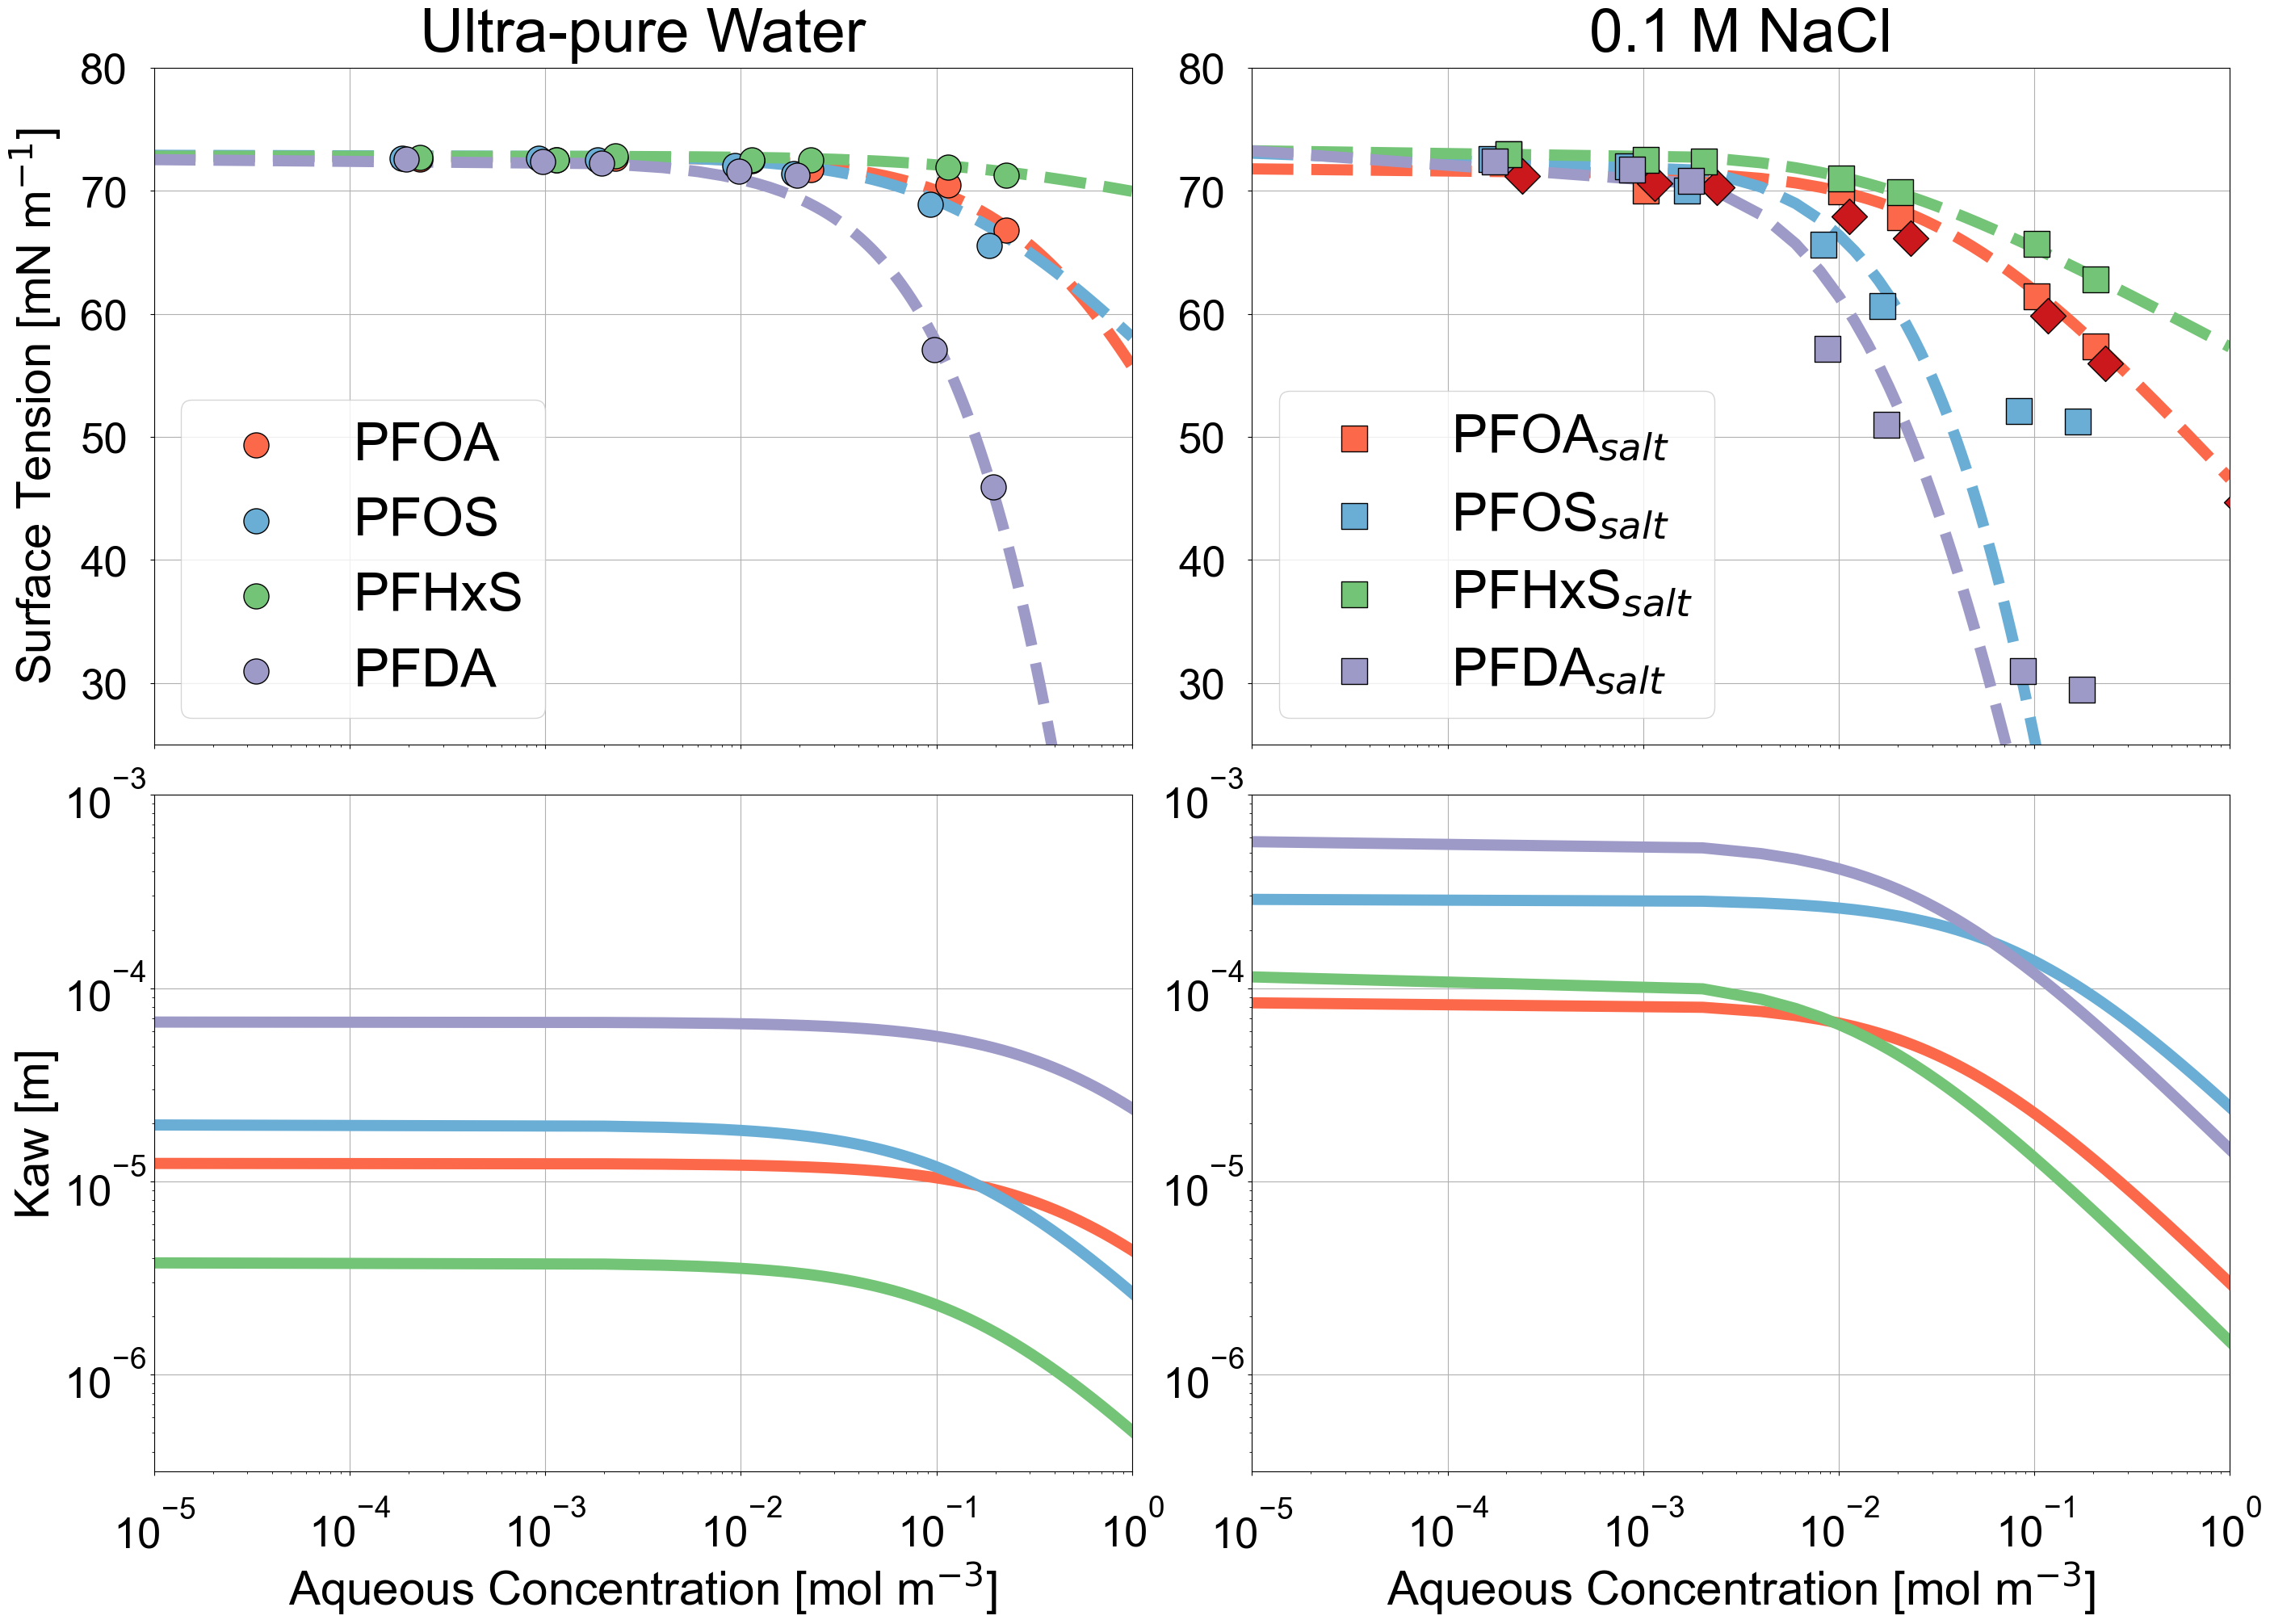

In [45]:
#Color schemes
pfoacolors = plt.cm.Reds(np.linspace(0,1,5))
pfoscolors = plt.cm.Blues(np.linspace(0,1,5))
pfhxscolors = plt.cm.Greens(np.linspace(0,1,5))
pfdacolors = plt.cm.Purples(np.linspace(0,1,5))

#plot art
mi = 'o' #marker icon
mi2 = 's'
ms = 500 # marker size
lw = 10 #linewidth
ls = '--'
ft = 42
ftt = 54
lab_size = 38
lab_pad = 22
leg_size = 48

#Lanmgmuir SFT plots
fig0, ([ax, ax1], [ax2, ax3]) =  plt.subplots(2, 2, figsize=(28, 20), dpi=dpi, sharex=True, constrained_layout=True)


#PFAS measured data in ultrapure water========================================
ax.scatter(pfoa_conc_sft*1000, pfoa_meas, color=pfoacolors[2], s = ms, marker = mi, edgecolor = 'black', zorder = 10, label = 'PFOA')
ax.scatter(pfos_conc_sft*1000, pfos_meas, color=pfoscolors[2], s = ms, marker = mi, edgecolor = 'black', zorder = 10,label = 'PFOS')
ax.scatter(pfhxs_conc_sft*1000, pfhxs_meas, color=pfhxscolors[2], s = ms, marker = mi, edgecolor = 'black', zorder = 10,label = 'PFHxS')
ax.scatter(pfda_conc_sft*1000, pfda_meas, color=pfdacolors[2], s = ms, marker = mi, edgecolor = 'black', zorder = 10,label = 'PFDA')

#PFAS langmuir fits in ultra pure=============================================
ax.plot(conc_model*1000, pfoa_sft_l, color=pfoacolors[2], lw = lw, ls = ls)
ax.plot(conc_model*1000, pfos_sft_l, color=pfoscolors[2], lw = lw, ls = ls)
ax.plot(conc_model*1000, pfhxs_sft_l, color=pfhxscolors[2], lw = lw, ls = ls)
ax.plot(conc_model*1000, pfda_sft_l, color=pfdacolors[2], lw = lw, ls = ls)


ax.set_title('Ultra-pure Water', fontsize = ftt, pad = 15)
ax.set_ylabel('Surface Tension [mN m$^{-1}$]', fontsize = ft, labelpad = 15)
ax.set_xscale('log')
ax.set_ylim(25, 80)
ax.set_xlim(10**-5, 10**0)
ax.grid()
ax.tick_params(axis='y', labelsize=lab_size, pad = 20)
ax.legend(loc =3, prop={'size': leg_size})


ax1.scatter(pfoa_nacl_conc_sft*1000, pfoa_nacl_meas, color=pfoacolors[2], s = ms, marker = mi2, edgecolor = 'black', zorder = 10,label = 'PFOA$_{salt}$')
ax1.scatter(pfoa_bruss_conc_sft*1000, pfoa_bruss_meas, color=pfoacolors[3], s = ms, marker = 'D', edgecolor = 'black', zorder = 10)
ax1.scatter(pfos_nacl_conc_sft*1000, pfos_nacl_meas, color=pfoscolors[2], s = ms, marker = mi2, edgecolor = 'black', zorder = 10,label = 'PFOS$_{salt}$')
ax1.scatter(pfhxs_nacl_conc_sft*1000, pfhxs_nacl_meas, color=pfhxscolors[2], s = ms, marker = mi2, edgecolor = 'black', zorder = 10,label = 'PFHxS$_{salt}$')
ax1.scatter(pfda_nacl_conc_sft*1000, pfda_nacl_meas, color=pfdacolors[2], s = ms, marker = mi2, edgecolor = 'black', zorder = 10,label = 'PFDA$_{salt}$')

ax1.plot(conc_model*1000, pfoa_nacl_sft_l, color=pfoacolors[2], lw = lw, ls = ls)
ax1.plot(conc_model*1000, pfos_nacl_sft_l, color=pfoscolors[2], lw = lw, ls = ls)
ax1.plot(conc_model*1000, pfhxs_nacl_sft_l, color=pfhxscolors[2], lw = lw, ls = ls)
ax1.plot(conc_model*1000, pfda_nacl_sft_l, color=pfdacolors[2], lw = lw, ls = ls)

ax1.set_title('0.1 M NaCl', fontsize = ftt, pad = 15)
ax1.set_xscale('log')
ax1.set_ylim(25, 80)
ax1.grid()
ax1.tick_params(axis='y', labelsize=lab_size, pad = 20)
ax1.legend(loc =3, prop={'size': leg_size})


#KAW====================================================================================
#ultra-pure
ax2.plot(conc_model*1000, pfoa_kaw_l, color=pfoacolors[2], lw = lw)
ax2.plot(conc_model*1000, pfos_kaw_l, color=pfoscolors[2], lw = lw)
ax2.plot(conc_model*1000, pfhxs_kaw_l, color=pfhxscolors[2], lw = lw)
ax2.plot(conc_model*1000, pfda_kaw_l, color=pfdacolors[2], lw = lw)

ax2.set_xlabel('Aqueous Concentration [mol m$^{-3}$]', fontsize = ft)
ax2.set_ylabel('Kaw [m]', fontsize = ft)
ax2.tick_params(axis='y', labelsize=lab_size,)
ax2.tick_params(axis='x', labelsize=lab_size, pad = lab_pad)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(10**-6.5, 10**-3)
ax2.grid()

#salt
ax3.plot(conc_model*1000, pfoa_nacl_kaw_l, color=pfoacolors[2], lw = lw)
ax3.plot(conc_model*1000, pfos_nacl_kaw_l, color=pfoscolors[2], lw = lw)
ax3.plot(conc_model*1000, pfhxs_nacl_kaw_l, color=pfhxscolors[2], lw = lw)
ax3.plot(conc_model*1000, pfda_nacl_kaw_l, color=pfdacolors[2], lw = lw)

ax3.set_xlabel('Aqueous Concentration [mol m$^{-3}$]', fontsize = ft)
ax3.tick_params(axis='y', labelsize=lab_size)
ax3.tick_params(axis='x', labelsize=lab_size, pad = lab_pad)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim(10**-6.5, 10**-3)
ax3.grid()

# Measured and Estimated Site Parameters

In [26]:
#-- 1D Estimated Retardatin in vadose zone

#Site Specific Parameters=================================================================================
Sr_ORA = 0.05 #residual water saturation
Pc_kpa = np.linspace(0, 30, 100) #approimate capillary pressure range from measured SWCC
density = 1 #desity of water g/cm3
haw = (Pc_kpa / 9.81*density)*100 #height above water table [cm]

#entry Pressure Values===================================================================================
a_gsand = 0.25 #entry pressure of 4 kPa
a_fsand = 0.08 #sactually the fine-sand
a_silt = 0.055 #actually the silty-sand
n_val = 4.0 #pore-size distribution

#Porous Media Properties==================================================================================
RH_U = 4.99#5.08 #uniformity coefficent
BET = 5 #spefici surface area in m2/g
phi = 0.42 #porosity
rhob = 1.53 #averaged dry bulk density?? <--- use this
s = (BET*100**2)*rhob #specific surface area in 1/cm
OC_dis = (1*10**-6)*np.exp(0.3621*(Pc_kpa)) #distribution of organic carbon

## Solid-phase Sorption Coeffs

Values are averaged from reported range (ITRC database: https://pfas-1.itrcweb.org/4-physical-and-chemical-properties/) unless speficied

In [27]:
#PFOA=============================================================================================
pfoa_koc = (10**2.62) #averaged lit values for PFOA

#PFOS=================================================================================================
pfos_koc = (10**3.41) #averaged lit values for     alt literature values for PFOS (2.8)
pfos_km = 0.1 #calculated Kd from LCMS - assumed completely associated with mineral phase adsorption
pfos_km_nacl = 0.34

#PFHxS==============================================================================================
pfhxs_koc = (10**2.71) #averaged lit values for PFHxS

#PFDA=============================================================================================
pfda_koc = (10**3.65) #averaged lit values for PFDA


## Kaw estimates (calculated above)


In [28]:
#print out some values (note, the units are in centimeters)
print(pfoa_kaw, pfos_kaw, pfhxs_kaw, pfda_kaw)

0.0012386260965416742 0.0027700889804990925 0.0005357384291028777 0.00667263409219815


# 1-D Retardation Profiles

Produce the retardation profile in the vadose zone for PFAAs. Retardation profiles and depth averages (equation 11) are calcuated for two representative capillary pressure profiles (gravelly-sand and silt)
## PFAAs in ultrapure water

In [29]:
#PFOA========================================================================================================
R_pfoa_gsand = vadoseRetaration_profile_func(a_gsand, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfoa_kaw, pfoa_koc, OC_dis, 0)

R_pfoa_silt = vadoseRetaration_profile_func(a_silt, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfoa_kaw, pfoa_koc, OC_dis, 0)
    
#calculatiing depth averaged R (See Valocchi 1989)
#Total Retardation
R_bar_pfoa_gsand = 1/haw[-1] * np.trapz(R_pfoa_gsand[0], haw) 
R_bar_pfoa_silt = 1/haw[-1] * np.trapz(R_pfoa_silt[0], haw) 

#air-water retardation
R_bar_aw_pfoa_gsand = 1/haw[-1] * np.trapz(R_pfoa_gsand[1], haw) 
R_bar_pfoa_aw_silt = 1/haw[-1] * np.trapz(R_pfoa_silt[1], haw) 

#Solid-phase retardation 
R_bar_sp_pfoa_gsand = 1/haw[-1] * np.trapz(R_pfoa_gsand[2], haw) 
R_bar_pfoa_sp_silt = 1/haw[-1] * np.trapz(R_pfoa_silt[2], haw) 



In [30]:
#gravelly-sand
R_pfos_gsand = vadoseRetaration_profile_func(a_gsand, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfos_kaw, pfos_koc, OC_dis, pfos_km)
#fine-sand
R_pfos_fine = vadoseRetaration_profile_func(a_fsand, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfos_kaw, pfos_koc, OC_dis, pfos_km)
#silty sand
R_pfos_silt = vadoseRetaration_profile_func(a_silt, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfos_kaw, pfos_koc, OC_dis, pfos_km)
    
#calculatiing depth averaged R see Valocchi (1988)
R_bar_pfos_gsand = 1/haw[-1] * np.trapz(R_pfos_gsand[0], haw) 
R_bar_pfos_fine  = 1/haw[-1] * np.trapz(R_pfos_fine[0],  haw) 
R_bar_pfos_silt  = 1/haw[-1] * np.trapz(R_pfos_silt[0],  haw) 

R_bar_aw_pfos_gsand = 1/haw[-1] * np.trapz(R_pfos_gsand[1], haw) 
R_bar_pfos_aw_silt = 1/haw[-1] * np.trapz(R_pfos_silt[1], haw) 

R_bar_sp_pfos_gsand = 1/haw[-1] * np.trapz(R_pfos_gsand[2], haw) 
R_bar_pfos_sp_silt = 1/haw[-1] * np.trapz(R_pfos_silt[2], haw) 


#Now lets make an assumption of a bulk OC content ~ 1.7 % 
R_pfos_oc = vadoseRetaration_profile_func(a_gsand, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfos_kaw, pfos_koc, 0.017, pfos_km)
R_bar_pfos_oc = 1/haw[-1] * np.trapz(R_pfos_oc[0], haw) 

In [31]:
#PFHxS========================================================================================================
R_pfhxs_gsand = vadoseRetaration_profile_func(a_gsand, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfhxs_kaw, pfhxs_koc, OC_dis, 0)

R_pfhxs_silt = vadoseRetaration_profile_func(a_silt, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfhxs_kaw, pfhxs_koc, OC_dis, 0)
    
#calculatiing depth averaged R from Valocchi paper
R_bar_pfhxs_gsand = 1/haw[-1] * np.trapz(R_pfhxs_gsand[0], haw) 
R_bar_pfhxs_silt = 1/haw[-1] * np.trapz(R_pfhxs_silt[0], haw) 

R_bar_aw_pfhxs_gsand = 1/haw[-1] * np.trapz(R_pfhxs_gsand[1], haw) 
R_bar_pfhxs_aw_silt = 1/haw[-1] * np.trapz(R_pfhxs_silt[1], haw) 

R_bar_sp_pfhxs_gsand = 1/haw[-1] * np.trapz(R_pfhxs_gsand[2], haw) 
R_bar_pfhxs_sp_silt = 1/haw[-1] * np.trapz(R_pfhxs_silt[2], haw) 


In [32]:
#PFDA========================================================================================================
R_pfda_gsand = vadoseRetaration_profile_func(a_gsand, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfda_kaw, pfda_koc, OC_dis, 0)

R_pfda_silt = vadoseRetaration_profile_func(a_silt, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfda_kaw, pfda_koc, OC_dis, 0)
    
#calculatiing depth averaged R from Valocchi paper
R_bar_pfda_gsand = 1/haw[-1] * np.trapz(R_pfda_gsand, haw) 
R_bar_pfda_silt = 1/haw[-1] * np.trapz(R_pfda_silt[0], haw) 

R_bar_aw_pfda_gsand = 1/haw[-1] * np.trapz(R_pfda_gsand[1], haw)
R_bar_pfda_aw_silt = 1/haw[-1] * np.trapz(R_pfda_silt[1], haw)

R_bar_sp_pfda_gsand = 1/haw[-1] * np.trapz(R_pfda_gsand[2], haw) 
R_bar_pfda_sp_silt = 1/haw[-1] * np.trapz(R_pfda_silt[2], haw) 


### PFAAs in 0.1 M NaCl solution

In [33]:
#PFOS in 0.1 M NaCl
R_nacl_pfos_gsand = vadoseRetaration_profile_func(a_gsand, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfos_nacl_kaw, pfos_koc, OC_dis, pfos_km_nacl)

R_nacl_pfos_silt = vadoseRetaration_profile_func(a_silt, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfos_nacl_kaw, pfos_koc, OC_dis, pfos_km_nacl)
    
#calculatiing depth averaged R from Valocchi paper
R_bar_nacl_pfos_gsand = 1/haw[-1] * np.trapz(R_nacl_pfos_gsand[0], haw) 
R_bar_nacl_pfos_silt = 1/haw[-1] * np.trapz(R_nacl_pfos_silt[0], haw)

R_bar_aw_nacl_pfos_gsand = 1/haw[-1] * np.trapz(R_nacl_pfos_gsand[1], haw)
R_bar_aw_nacl_pfos_silt = 1/haw[-1] * np.trapz(R_nacl_pfos_silt[1], haw)

R_bar_sp_nacl_pfos_gsand = 1/haw[-1] * np.trapz(R_nacl_pfos_gsand[2], haw) 
R_bar_sp_nacl_pfos_silt = 1/haw[-1] * np.trapz(R_nacl_pfos_silt[2], haw)

In [34]:
#PFHxS========================================================================================================
R_nacl_pfhxs_gsand = vadoseRetaration_profile_func(a_gsand, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfhxs_nacl_kaw, pfhxs_koc, OC_dis, 0)

R_nacl_pfhxs_silt = vadoseRetaration_profile_func(a_silt, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfhxs_nacl_kaw, pfhxs_koc, OC_dis, 0)
    
#calculatiing depth averaged R from Valocchi paper
R_bar_nacl_pfhxs_gsand = 1/haw[-1] * np.trapz(R_nacl_pfhxs_gsand[0], haw) 
R_bar_nacl_pfhxs_silt = 1/haw[-1] * np.trapz(R_nacl_pfhxs_silt[0], haw)

R_bar_aw_nacl_pfhxs_gsand = 1/haw[-1] * np.trapz(R_nacl_pfhxs_gsand[1], haw) 
R_bar_aw_nacl_pfhxs_silt = 1/haw[-1] * np.trapz(R_nacl_pfhxs_silt[1], haw)

R_bar_sp_nacl_pfhxs_gsand = 1/haw[-1] * np.trapz(R_nacl_pfhxs_gsand[2], haw) 
R_bar_sp_nacl_pfhxs_silt = 1/haw[-1] * np.trapz(R_nacl_pfhxs_silt[2], haw)

In [35]:
#PFOA========================================================================================================
R_nacl_pfoa_gsand = vadoseRetaration_profile_func(a_gsand, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfoa_nacl_kaw, pfoa_koc, OC_dis, 0)

R_nacl_pfoa_silt = vadoseRetaration_profile_func(a_silt, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfoa_nacl_kaw, pfoa_koc, OC_dis, 0)

#calculatiing depth averaged R from Valocchi paper
R_bar_nacl_pfoa_gsand = 1/haw[-1] * np.trapz(R_nacl_pfoa_gsand[0], haw)
R_bar_nacl_pfoa_silt = 1/haw[-1] * np.trapz(R_nacl_pfoa_silt[0], haw)

R_bar_aw_nacl_pfoa = 1/haw[-1] * np.trapz(R_nacl_pfoa_gsand[1], haw) 
R_bar_aw_nacl_pfoa_silt = 1/haw[-1] * np.trapz(R_nacl_pfoa_silt[1], haw)
 
R_bar_sp_nacl_pfoa = 1/haw[-1] * np.trapz(R_nacl_pfoa_gsand[2], haw) 
R_bar_sp_nacl_pfoa_silt = 1/haw[-1] * np.trapz(R_nacl_pfoa_silt[2], haw)

In [36]:
#PFDA========================================================================================================
R_nacl_pfda_gsand = vadoseRetaration_profile_func(a_gsand, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfda_nacl_kaw, pfda_koc, OC_dis, 0)

R_nacl_pfda_silt = vadoseRetaration_profile_func(a_silt, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfda_nacl_kaw, pfda_koc, OC_dis, 0)
    
#calculatiing depth averaged R from Valocchi paper
R_bar_nacl_pfda_gsand = 1/haw[-1] * np.trapz(R_nacl_pfda_gsand[0], haw) 
R_bar_nacl_pfda_silt = 1/haw[-1] * np.trapz(R_nacl_pfda_silt[0], haw)

R_bar_aw_nacl_pfda_gsand = 1/haw[-1] * np.trapz(R_nacl_pfda_gsand[1], haw) 
R_bar_aw_nacl_pfda_silt = 1/haw[-1] * np.trapz(R_nacl_pfda_silt[1], haw)

R_bar_sp_nacl_pfda_gsand = 1/haw[-1] * np.trapz(R_nacl_pfda_gsand[2], haw) 
R_bar_sp_nacl_pfda_silt = 1/haw[-1] * np.trapz(R_nacl_pfda_silt[2], haw)

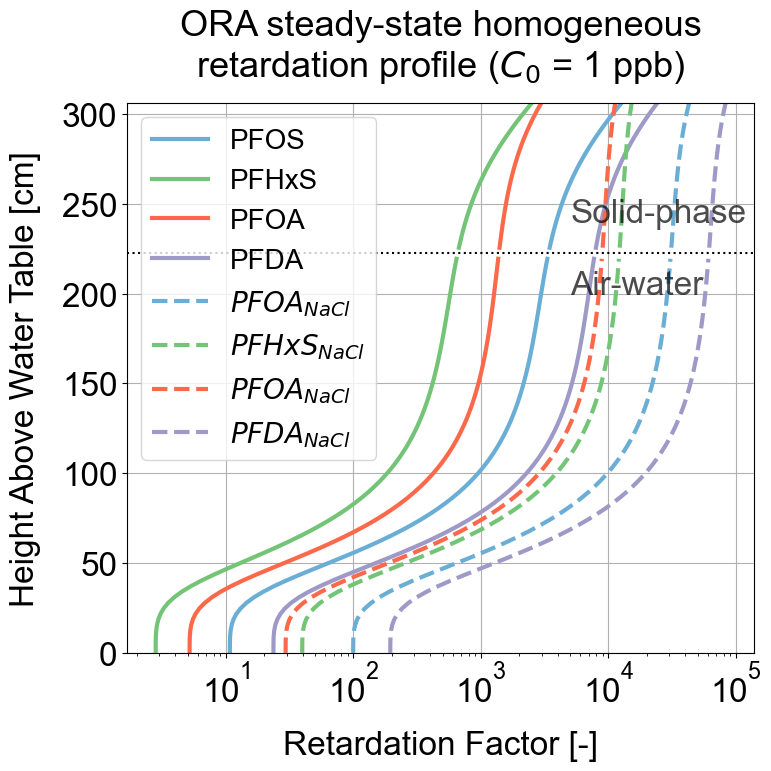

In [37]:
#%% - 1D retaration profile for gravely-sand profile
#Plotting====================================================================================================
fig_R, (ax) =  plt.subplots(1, 1, figsize=(8, 8), dpi=dpi)

rpfos_aw, = ax.plot(R_pfos_gsand[0][:72], haw[:72], label = 'PFOS', linewidth = 3, c=pfoscolors[2])
rpfos_sp, = ax.plot(R_pfos_gsand[0][73:], haw[73:], linewidth = 3, c=pfoscolors[2])

rpfhxs_aw, = ax.plot(R_pfhxs_gsand[0][:72], haw[:72], label = 'PFHxS', linewidth = 3, c=pfhxscolors[2])
rpfhxs_sp, = ax.plot(R_pfhxs_gsand[0][73:], haw[73:], linewidth = 3, c=pfhxscolors[2])

rpfoa_aw, = ax.plot(R_pfoa_gsand[0][:72], haw[:72],  label = 'PFOA', linewidth = 3, c=pfoacolors[2])
rpfoa_sp, = ax.plot(R_pfoa_gsand[0][73:], haw[73:], linewidth = 3, c=pfoacolors[2])

rpfda_aw, = ax.plot(R_pfda_gsand[0][:72], haw[:72],  label = 'PFDA', linewidth = 3, c=pfdacolors[2])
rpfda_sp, = ax.plot(R_pfda_gsand[0][73:], haw[73:], linewidth = 3, c=pfdacolors[2])

rpfos_nacl_aw, = ax.plot(R_nacl_pfos_gsand[0][:72], haw[:72], label = '$PFOA_{NaCl}$', linewidth = 3, c=pfoscolors[2], ls = '--')
rpfos_nacl_sp, = ax.plot(R_nacl_pfos_gsand[0][73:], haw[73:], linewidth = 3, c=pfoscolors[2], ls = '--')

rpfhxs_nacl_aw, = ax.plot(R_nacl_pfhxs_gsand[0][:72], haw[:72], label = '$PFHxS_{NaCl}$', linewidth = 3, c=pfhxscolors[2], ls = '--')
rpfhxs_nacl_sp, = ax.plot(R_nacl_pfhxs_gsand[0][73:], haw[73:], linewidth = 3, c=pfhxscolors[2], ls = '--')

rpfoa_nacl_aw, = ax.plot(R_nacl_pfoa_gsand[0][:72], haw[:72], label = '$PFOA_{NaCl}$', linewidth = 3, c=pfoacolors[2], ls = '--')
rpfoa_nacl_sp, = ax.plot(R_nacl_pfoa_gsand[0][73:], haw[73:], linewidth = 3, c=pfoacolors[2], ls = '--')

rpfda_nacl_aw, = ax.plot(R_nacl_pfda_gsand[0][:72], haw[:72], label = '$PFDA_{NaCl}$', linewidth = 3, c=pfdacolors[2], ls = '--')
rpfda_nacl_sp, = ax.plot(R_nacl_pfda_gsand[0][73:], haw[73:], linewidth = 3, c=pfdacolors[2], ls = '--')

#sp dominant line
sp_depth = haw[72]
ax.axhline(sp_depth, ls = ':', c = 'black')
#depth average values
# ax.axvline(R_bar_nacl_pfos, ls ='--', c=pfoscolors[2], label = round(R_bar_pfos))
# ax.axvline(R_bar_nacl_pfhxs, ls ='--', c=pfhxscolors[2], label = round(R_bar_pfhxs))
# #ax.axvline(R_bar_nacl_pfoa, ls ='--', c=pfoacolors[2], label = round(R_bar_pfoa))
# ax.axvline(R_bar_nacl_pfda, ls ='--', c=pfdacolors[2], label = round(R_bar_pfda))
ft = 26
ax.set_title('ORA steady-state homogeneous\nretardation profile ($C_0$ = {})'.format(conc_text[C]), pad = 20, fontsize = ft)
ax.set_xlabel('Retardation Factor [-]', fontsize = 24, labelpad = 15)
ax.set_ylabel('Height Above Water Table [cm]', fontsize = 24, labelpad = 15)
#ax.legend(handles=[rpfos_nacl, rpfhxs_nacl, rpfda_nacl])
#ax.set_xscale('log')
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(axis='x', labelsize=24)


#ax.set_xlim(0, 10**6)
ax.set_xscale('log')
ax.set_ylim(0, max(haw))
ax.grid('True')
ax.legend(loc = 2, prop={'size': 20})

#annotations
ax.annotate('Solid-phase', xy = (10**3.7, 240), xycoords = 'data', fontsize = 24, alpha = 0.7)
ax.annotate('Air-water', xy = (10**3.7, 200), xycoords = 'data', fontsize = 24, alpha = 0.7)

# xvals = [520, 100, 250, 1250, 2100, 1400, 2500]
#labelLines(ax.get_lines(),fontsize=14, align=True)#, xvals=xvals)
fig_R.tight_layout()

## Making comparisons between capilarry pressure profiles (gravely-sand vs silty-sand) for PFOS

[Text(100, 55.7113712257139, 'gravely-sand'),
 Text(80, 161.59705072878344, 'silty-sand')]

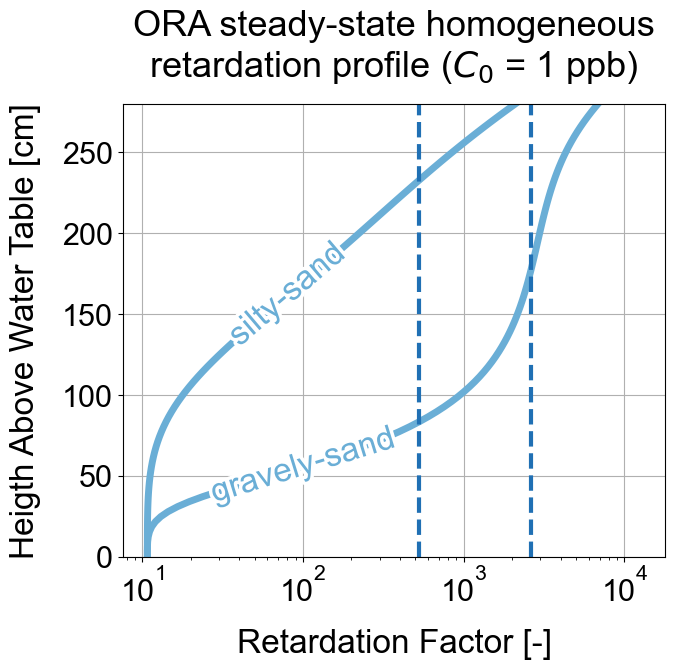

In [38]:
#%%PFOS example=================================================================================================================
fig_PFOS_1D, ax =  plt.subplots(1, 1, figsize=(7, 6), dpi=dpi)
ax.plot(R_pfos_gsand[0], haw, label = 'gravely-sand', linewidth = 5, c=pfoscolors[2])
#ax.plot(R_pfos_silt[0], haw, label = 'fine-sand', linewidth = 4, c=pfoscolors[2])
ax.plot(R_pfos_fine[0], haw, label = 'silty-sand', linewidth = 5, c=pfoscolors[2])

sp_depth = haw[72]
#ax.axhline(sp_depth, ls = ':', c = 'black', lw = 3)
ax.axvline(R_bar_pfos_gsand, ls = '--', c = pfoscolors[3], lw = 3)
#ax.axvline(R_bar_pfos_silt, ls = '--', c = pfoscolors[3], lw = 3)
ax.axvline(R_bar_pfos_fine, ls = '--', c = pfoscolors[3], lw = 3)

ft = 26
ax.set_title('ORA steady-state homogeneous\nretardation profile ($C_0$ = {})'.format(conc_text[C]), pad = 20, fontsize = ft)
ax.set_xlabel('Retardation Factor [-]', fontsize = 24, labelpad = 15)
ax.set_ylabel('Heigth Above Water Table [cm]', fontsize = 24, labelpad = 15)
#ax.legend(handles=[rpfos_nacl, rpfhxs_nacl, rpfda_nacl])

ax.tick_params(axis='y', labelsize=22)
ax.tick_params(axis='x', labelsize=22)

ax.set_xscale('log')
ax.set_ylim(0, 280)
ax.grid('True')
#ax.legend(loc = 4, prop={'size': 20})
labelLines(ax.get_lines(), fontsize=24, align=True, xvals=[100,80,200])

## Relative contributions of air-water and solid-phasee adsorption processes

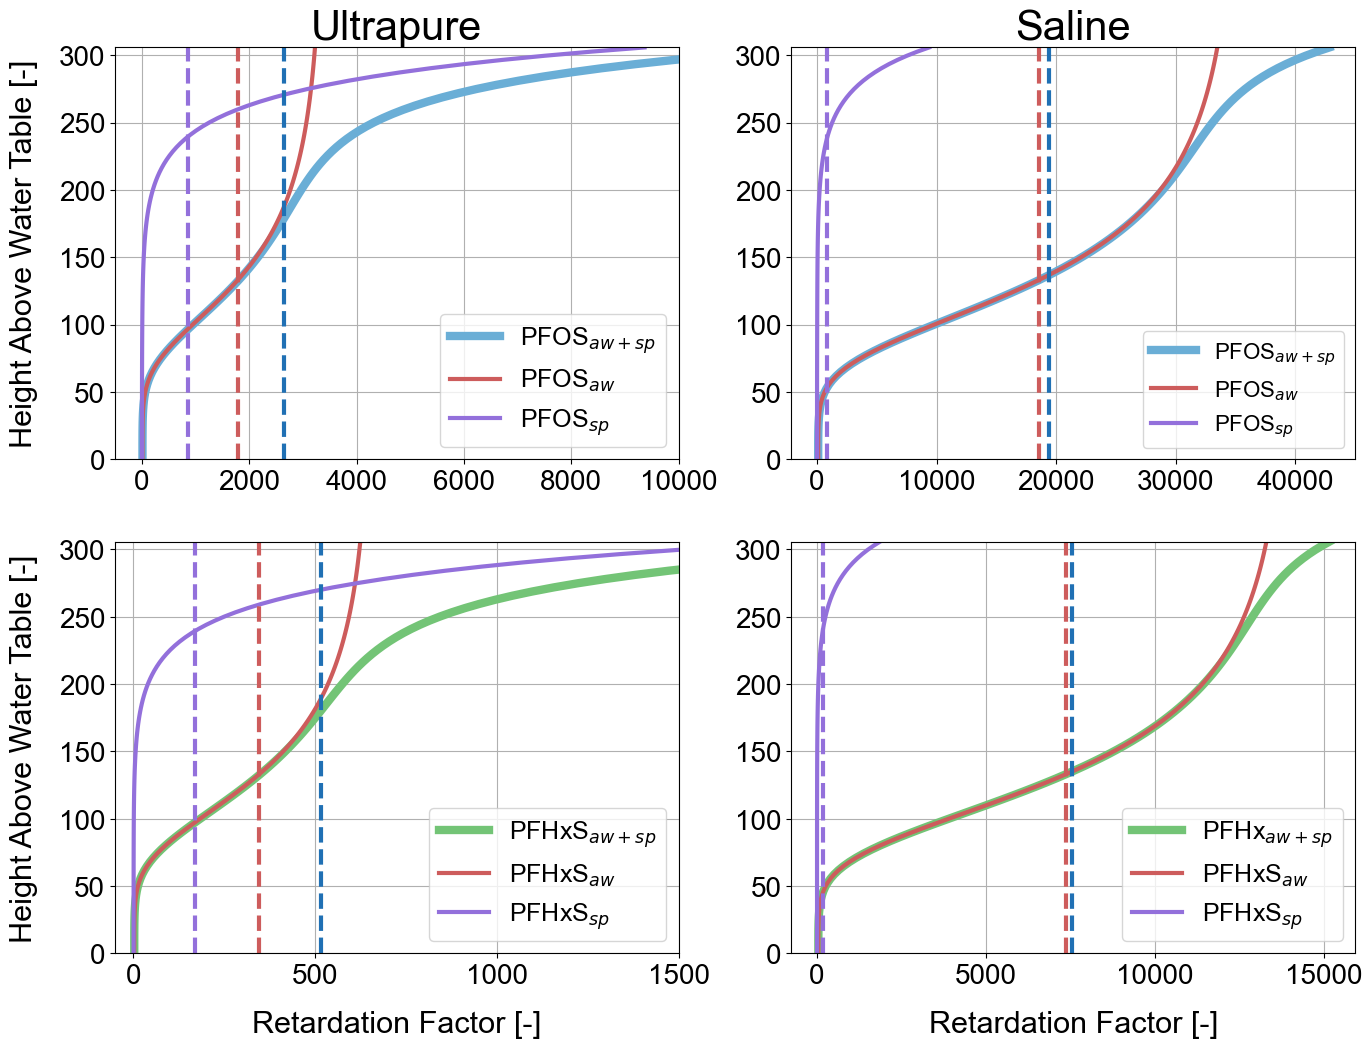

In [39]:
fig_comp, ([ax, ax1],[ax2, ax3],) = plt.subplots(2, 2, figsize=(16, 12), dpi=dpi)
linwid = 3
#ultrapure comparision
ax.plot(R_pfos_gsand[0], haw, label = 'PFOS$_{aw+sp}$', linewidth = 6, c=pfoscolors[2])
ax.plot(R_pfos_gsand[1], haw, label = 'PFOS$_{aw}$', linewidth = linwid, c='indianred')
ax.plot(R_pfos_gsand[2], haw, label = 'PFOS$_{sp}$', linewidth = linwid, c='mediumpurple')

ax.axvline(R_bar_pfos_gsand, ls = '--', c = pfoscolors[3], lw = 3)
ax.axvline(R_bar_aw_pfos_gsand, ls = '--', c = 'indianred', lw = 3)
ax.axvline(R_bar_sp_pfos_gsand, ls = '--', c = 'mediumpurple', lw = 3)

ax.set_ylabel('Height Above Water Table [-]', fontsize = 22, labelpad=15)
ax.set_title('Ultrapure', fontsize = 30)
ax.set_ylim(0, max(haw))
ax.set_xlim(-500, 10000)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.legend(loc = 4, prop={'size': 18})
ax.grid()

ax2.plot(R_pfhxs_gsand[0], haw, label = 'PFHxS$_{aw+sp}$', linewidth = 6, c=pfhxscolors[2])
ax2.plot(R_pfhxs_gsand[1], haw, label = 'PFHxS$_{aw}$', linewidth = linwid, c='indianred')
ax2.plot(R_pfhxs_gsand[2], haw, label = 'PFHxS$_{sp}$', linewidth = linwid, c='mediumpurple')

ax2.axvline(R_bar_pfhxs_gsand, ls = '--', c = pfoscolors[3], lw = 3)
ax2.axvline(R_bar_aw_pfhxs_gsand, ls = '--', c = 'indianred', lw = 3)
ax2.axvline(R_bar_sp_pfhxs_gsand, ls = '--', c = 'mediumpurple', lw = 3)

ax2.set_xlabel('Retardation Factor [-]', fontsize = 22, labelpad=15)
ax2.set_ylabel('Height Above Water Table [-]', fontsize = 22, labelpad=15)
ax2.set_ylim(0, max(haw))
ax2.set_xlim(-50, 1500)
ax2.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.legend(loc = 4, prop={'size': 18})
ax2.grid()


#saline
ax1.plot(R_nacl_pfos_gsand[0], haw, label = 'PFOS$_{aw+sp}$', linewidth = 6, c=pfoscolors[2])
ax1.plot(R_nacl_pfos_gsand[1], haw, label = 'PFOS$_{aw}$', linewidth = linwid, c='indianred')
ax1.plot(R_nacl_pfos_gsand[2], haw, label = 'PFOS$_{sp}$', linewidth = linwid, c='mediumpurple')

ax1.axvline(R_bar_nacl_pfos_gsand, ls = '--', c = pfoscolors[3], lw = 3)
ax1.axvline(R_bar_aw_nacl_pfos_gsand, ls = '--', c = 'indianred', lw = 3)
ax1.axvline(R_bar_sp_nacl_pfos_gsand, ls = '--', c = 'mediumpurple', lw = 3)

ax1.set_title('Saline', fontsize = 30)
ax1.set_ylim(0, max(haw))
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.legend(loc = 4, prop={'size': 16})
ax1.grid()

ax3.plot(R_nacl_pfhxs_gsand[0], haw, label = 'PFHx$_{aw+sp}$', linewidth = 6, c=pfhxscolors[2])
ax3.plot(R_nacl_pfhxs_gsand[1], haw, label = 'PFHxS$_{aw}$', linewidth = linwid, c='indianred')
ax3.plot(R_nacl_pfhxs_gsand[2], haw, label = 'PFHxS$_{sp}$', linewidth = linwid, c='mediumpurple')

ax3.axvline(R_bar_nacl_pfhxs_gsand, ls = '--', c = pfoscolors[3], lw = 3)
ax3.axvline(R_bar_aw_nacl_pfhxs_gsand, ls = '--', c = 'indianred', lw = 3)
ax3.axvline(R_bar_sp_nacl_pfhxs_gsand, ls = '--', c = 'mediumpurple', lw = 3)

ax3.set_xlabel('Retardation Factor [-]', fontsize = 22, labelpad=15)
# ax2.set_ylabel('Height Above Water Table [-]', fontsize = 22, labelpad=15)
ax3.set_ylim(0, max(haw))
# ax3.set_xlim(-50, 1500)
ax3.tick_params(axis='y', labelsize=20)
ax3.tick_params(axis='x', labelsize=20)
ax3.legend(loc = 4, prop={'size': 18})
ax3.grid()

## Comparing organic carbon distributions vs bulk averaged in soils 

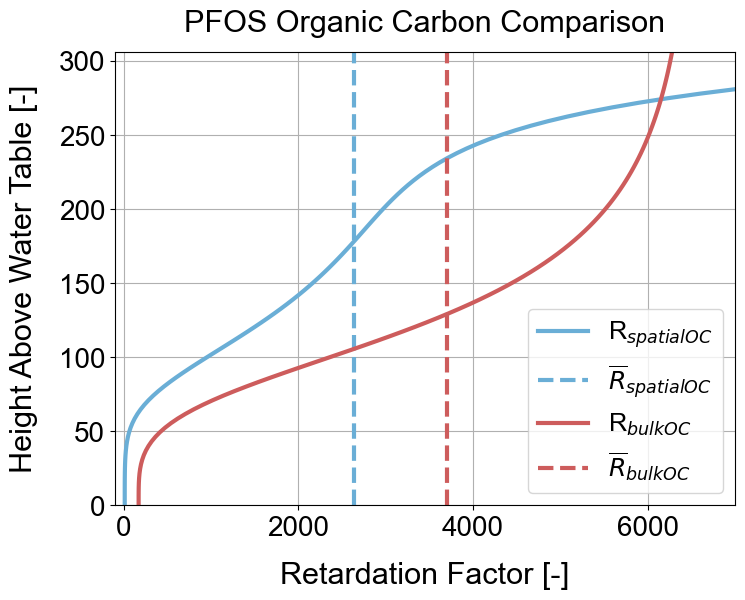

In [46]:
fig_PFOS_oc, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=dpi)
linwid = 3
#ultrapure comparision
ax.plot(R_pfos_gsand[0], haw, label = 'R$_{spatial OC}$', linewidth = linwid, c=pfoscolors[2])
ax.axvline(R_bar_pfos_gsand, ls = '--', c = pfoscolors[2], lw = 3, label = r'$\overline {R}_{spatialOC}$')


ax.plot(R_pfos_oc[0], haw, label = 'R$_{bulk OC}$', linewidth = linwid, c='indianred')
ax.axvline(R_bar_pfos_oc, ls = '--', c = 'indianred', lw = 3, label = r'$\overline {R}_{bulkOC}$')

ax.set_title('PFOS Organic Carbon Comparison', fontsize = 22, pad =15)

ax.set_ylabel('Height Above Water Table [-]', fontsize = 22, labelpad=15)
ax.set_xlabel('Retardation Factor [-]', fontsize = 22, labelpad=15)

ax.set_ylim(0, max(haw))
ax.set_xlim(-100, 7000)

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

# ax.set_xscale('log')
ax.legend(loc = 4, prop={'size': 18})

ax.grid()

# 2-D Retardation Surfaces
Here, the Van Genuchten parameter av (entry pressure) is varied across the range of representative values for a fixed nv (pore-size distribution).

In [41]:
#%% - Surface plots -- note something above changes the surface map so run this before making the other plots

#ranging across values of av and pc
av = np.array(np.linspace(0.01, 1, 100))

#call surface retardation function
#PFOS=============================================================================================================
R_out_pfos = vadoseRetaration_2Dprofile_func(av, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, 
                                                                    pfos_kaw, pfos_koc, OC_dis, pfos_km)

#PFHxS=============================================================================================================
R_out_pfhxs = vadoseRetaration_2Dprofile_func(av, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, 
                                                                    pfhxs_kaw, pfhxs_koc, OC_dis, 0)

#PFOA=============================================================================================================
R_out_pfoa = vadoseRetaration_2Dprofile_func(av, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, 
                                                                    pfoa_kaw, pfoa_koc, OC_dis, 0)

#PFOA=============================================================================================================
R_out_pfda = vadoseRetaration_2Dprofile_func(av, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, 
                                                                    pfda_kaw, pfda_koc, OC_dis, 0)

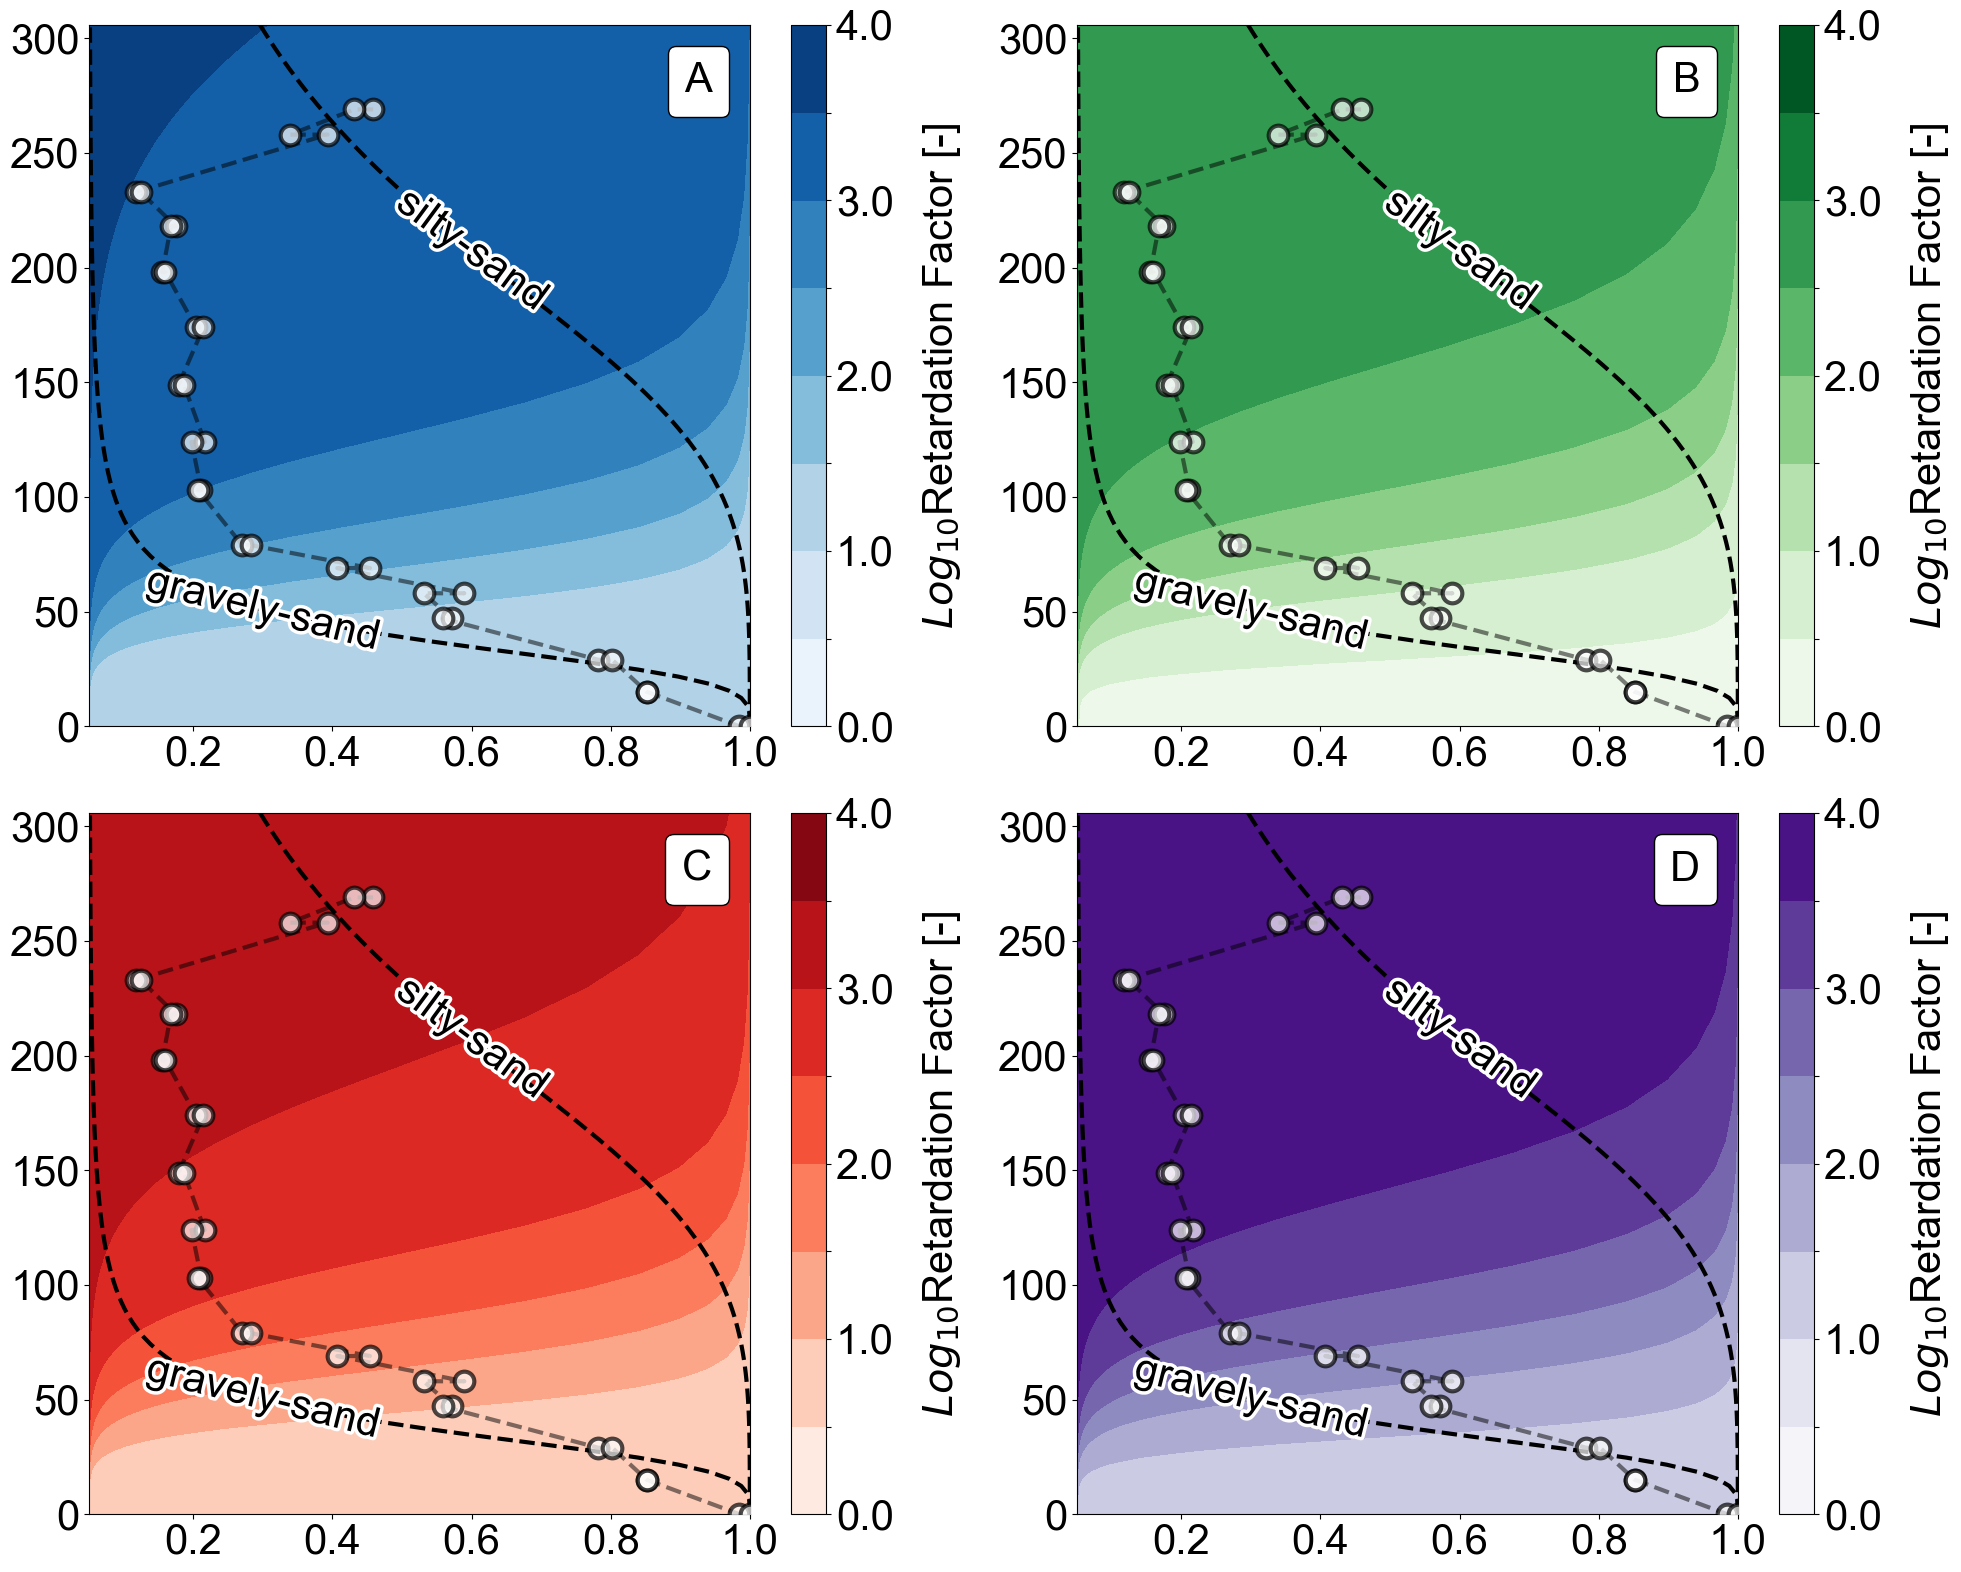

In [42]:
#1D range of Sw values 
for i in av:
    for j in Pc_kpa:
        Sw = Sw_func(av, 4, Pc_kpa, Sr_ORA)

#Separate plot for total retardation
fig_2D, ([ax, ax1],[ax2, ax3]) =  plt.subplots(2, 2, figsize=(20, 16), dpi=dpi)

#fig_2D, (ax1, ax2, ax, ax3) =  plt.subplots(1, 4, figsize=(28, 8), dpi=200)

ft = 30
pds = 20
level_test = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4.0]

im = ax.contourf(Sw, haw, np.log10(R_out_pfos[0]), level_test, cmap = 'Blues')
cbar = fig_2D.colorbar(im, ax=ax)
cbar.set_label(label='$Log_{10}$Retardation Factor [-]', size = ft, labelpad = pds)
cbar.ax.tick_params(labelsize=ft) 
for label in cbar.ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)


#ax.set_title('PFOS retardation, $C_0 = {}$'.format(conc_text[C]), fontsize = ft, pad=pds)
#ax.set_ylabel('Height above water table [cm]', fontsize = ft)
ax.tick_params(axis='y', labelsize=ft)
ax.tick_params(axis='x', labelsize=ft)

im1 = ax1.contourf(Sw, haw, np.log10(R_out_pfhxs[0]), level_test, cmap = 'Greens')
cbar = fig_2D.colorbar(im1, ax=ax1)
cbar.set_label(label='$Log_{10}$Retardation Factor [-]', size = ft, labelpad = 20)
cbar.ax.tick_params(labelsize=ft) 
for label in cbar.ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

#ax1.set_title('PFHxS retardation, $C_0 = {}$'.format(conc_text[C]), fontsize = ft, pad=pds)
ax1.tick_params(axis='y', labelsize=ft)
ax1.tick_params(axis='x', labelsize=ft)

im2 = ax2.contourf(Sw, haw, np.log10(R_out_pfoa[0]), level_test, cmap = 'Reds')
cbar = fig_2D.colorbar(im2, ax=ax2)
cbar.set_label(label='$Log_{10}$Retardation Factor [-]', size = ft, labelpad = 20)
cbar.ax.tick_params(labelsize=ft) 
for label in cbar.ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

ax2.tick_params(axis='y', labelsize=ft)
ax2.tick_params(axis='x', labelsize=ft)

im3 = ax3.contourf(Sw, haw, np.log10(R_out_pfda[0]), level_test, cmap = 'Purples')
cbar = fig_2D.colorbar(im3, ax=ax3)
cbar.set_label(label='$Log_{10}$Retardation Factor [-]', size = ft, labelpad = 20)
cbar.ax.tick_params(labelsize=ft) 
for label in cbar.ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

ax3.tick_params(axis='y', labelsize=ft)
ax3.tick_params(axis='x', labelsize=ft)

#actual B006 profile
Sw_B004 = np.array([0.213208020050125, 0.214745762711865, 0.368404737534727, 0.370619047619048, 
                    0.284150537634409, 0.283969568892646, 0.243361344537815, 0.233676875114616, 
                    0.208460686600221, 0.208887998397115, 0.189209699711019, 0.191699507389162, 
                    0.152599531615924, 0.165651365651366, 0.136269527573875, 0.148271728271729, 
                    0.139743492063492, 0.134092332833992, 0.21468416988417, 0.227485021967781, 
                    0.370490405117271, 0.36953120665742, 0.614019392372334, 0.628207094918504, 
                    0.723143645682744, 0.693631610942249, 0.807926887926888, 0.776729884412524, 
                    0.958964729764019, 0.886779987944545, 0.934317578332449, 1
])

haw_B004 = np.array([207, 207, 192, 192, 176, 176, 167, 167, 159, 159, 136, 136, 115, 115, 96, 
                     96, 76, 76, 56, 56, 46, 46, 35, 35, 26, 26, 16, 16, 4, 4, 0, 0
])

Sw_B006 = np.array([0.458333333333333, 0.43137107980709, 0.33882001912235, 0.393006802721089, 
                    0.1178182589433, 0.124046097982484, 0.174709952474141, 0.167703175944934, 
                    0.155297735532569, 0.159672319632078, 0.203614586042993, 0.214513901891032, 
                    0.178871222047035, 0.186246355685131, 0.216292964554242, 0.197292571647132, 
                    0.211381706755321, 0.206659226190476, 0.270260927457558, 0.282242357523922, 
                    0.453766939846805, 0.40691117849477, 0.589559334026135, 0.53099459924485, 
                    0.571717247784723, 0.558749569866857, 0.782300990571667, 0.802127454755487, 
                    0.851893358499469, 0.852209711470796, 0.985170009784737, 1])

haw_B006 = np.array([269, 269, 258, 258, 233, 233, 218, 218, 198, 198, 174, 174, 149, 149, 124, 
                     124, 103, 103, 79, 79, 69, 69, 58, 58, 47, 47, 29, 29, 15, 15, 0, 0])

axes = [ax, ax1, ax2, ax3]
for i in axes:
    i.plot(Sw_func(0.3, n_val, Pc_kpa, Sr_ORA), haw, "--", c = 'black', linewidth = 3, label = "gravely-sand")
    i.plot(Sw_func(0.05, n_val, Pc_kpa, Sr_ORA), haw, '--', c = 'black', linewidth = 3, label = 'silty-sand')
    #i.plot(Sw_func(0.071, n_val, Pc_kpa, Sr_ORA), haw, '--', c = 'black', linewidth = 3, label = 'fine-sand')
    i.scatter(Sw_B006, haw_B006, c = 'white', linewidth = 3, s = 200, zorder = 10, alpha = 0.7, edgecolors='black')
    i.plot(Sw_B006, haw_B006, "--", c = 'black', linewidth = 3, alpha = 0.5)
    labelLines(i.get_lines(),fontsize=30, align=True, xvals=[0.3, 0.6, 0.6])
    #i.scatter(Sw_B004, haw_B004, color = 'black', label = "B004")
    
at = AnchoredText(
    "A", prop=dict(size=30), frameon=True, loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
at1 = AnchoredText(
    "B", prop=dict(size=30), frameon=True, loc='upper right')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at1)
at2 = AnchoredText(
    "C", prop=dict(size=30), frameon=True, loc='upper right')
at2.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at2)
at3 = AnchoredText(
    "D", prop=dict(size=30), frameon=True, loc='upper right')
at3.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at3)

fig_2D.tight_layout()

# Capillary Pressure Profile and field-scale heterogeneity

First, pull in the data files

In [43]:
#data -- #note the depth
Lab1 = pd.read_csv("B009004.csv") 
Lab2 = pd.read_csv("B0012004.csv")
Lab3 = pd.read_csv("B0012004DUP.csv")
Lab4 = pd.read_csv("B004002_Dense.csv")
Lab5 = pd.read_csv("B004002_Loose.csv")
Lab6 = pd.read_csv("B004007_Dense.csv")
Lab7 = pd.read_csv("B004007_Loose.csv")
Lab8 = pd.read_csv("B006009_Dense.csv")
Lab9 = pd.read_csv("B006009_Loose.csv")
Lab10 = pd.read_csv("B004013_Dense.csv")
Lab11 = pd.read_csv("B004013_Loose.csv")
Lab12 = pd.read_csv("B005003_Dense.csv")
Lab13 = pd.read_csv("B005003_Loose.csv")

Field1 = pd.read_csv("B004.csv")
Field2 = pd.read_csv("B006.csv")

#max_kpa = max()
h_corr = 100/(9.81*density)

#Borehole meaasurements: Water Saturation (SW), Height above water table (haw), and capillary pressure (Pc)
Pc_kpa_B004 = np.array([20.3067, 20.3067, 18.8352, 18.8352, 17.2656, 17.2656, 16.3827, 16.3827, 15.5979, 
                        15.5979, 13.3416, 13.3416, 11.2815, 11.2815, 9.4176, 9.4176, 7.4556, 7.4556, 5.4936, 
                        5.4936, 4.5126, 4.5126, 3.4335, 3.4335, 2.5506, 2.5506, 1.5696, 1.5696, 0.3924, 0.3924, 
                        0, 0])

Pc_kpa_B006 = np.array([26.3889, 26.3889, 25.3098, 25.3098, 22.8573, 22.8573, 21.3858, 21.3858, 
                        19.4238, 19.4238, 17.0694, 17.0694, 14.6169, 14.6169, 12.1644, 12.1644, 
                        10.1043, 10.1043, 7.7499, 7.7499, 6.7689, 6.7689, 5.6898, 5.6898, 4.6107,
                        4.6107, 2.8449, 2.8449, 1.4715, 1.4715, 0, 0])

fig, (ax, ax2, ax1) = plt.subplots(1, 3, figsize=(14,9), sharey=True, gridspec_kw={'width_ratios': [5, 1.5, 1.5]}, dpi=300)

#colors for data
lab_dat = 'dimgrey'
# #coloring by depth
Bdepths = 'grey' #'royalblue' #plt.cm.Blues(np.linspace(0,1,5))
Rdepths = 'grey' #'indianred' #plt.cm.Reds(np.linspace(0,1,5))
Gdepths = 'grey' #'forestgreen' #plt.cm.Greens(np.linspace(0,1,5))

field_dat = 'orangered'

#Loose measurements
Lab = ax.scatter(Lab5['S (measured)'], Lab5['Applied Suction (kPa)']*h_corr, label = 'Lab', c = Bdepths, s=100)#, edgecolor = 'black') 'B004002_Loose'
ax.scatter(Lab7['S (measured)'], Lab7['Applied Suction (kPa)']*h_corr, label = 'Lab', c = Bdepths, s=100)#, edgecolor = 'black') 'B004007_Loose'
ax.scatter(Lab9['S (measured)'], Lab9['Applied Suction (kPa)']*h_corr, label = 'Lab', c = Rdepths, s=100)#, edgecolor = 'black') 'B006009_Loose'
ax.scatter(Lab11['S (measured)'], Lab11['Applied Suction (kPa)']*h_corr, label = 'Lab', c = Bdepths, s=100)#, edgecolor = 'black') 'B004013_Loose'

#Dense measurements
ax.scatter(Lab4['S (measured)'], Lab4['Applied Suction (kPa)']*h_corr, label = 'Lab', c = Bdepths, s=100)#, edgecolor = 'black') 'B004002_Dense'
ax.scatter(Lab6['S (measured)'], Lab6['Applied Suction (kPa)']*h_corr, label = 'Lab', c = Bdepths, s=100)#, edgecolor = 'black') 'B004007_Dense'
ax.scatter(Lab8['S (measured)'], Lab8['Applied Suction (kPa)']*h_corr, label = 'Lab', c = Rdepths, s=100)#, edgecolor = 'black') 'B006009_Dense'
ax.scatter(Lab10['S (measured)'], Lab10['Applied Suction (kPa)']*h_corr, label = 'Lab', c = Bdepths, s=100)#, edgecolor = 'black') 'B004013_Dense'
ax.scatter(Lab12['S (measured)'], Lab12['Applied Suction (kPa)']*h_corr, label = 'Lab', c = Gdepths, s=100)#, edgecolor = 'b') #'B005003_Dense'

B004 = ax.scatter(Field1['S'], Field1['Pc kpa']*h_corr, label = 'B004', c = 'royalblue', s=100, edgecolor = 'black') #'B004'
# ax.plot(Field1['S'], Field1['Pc kpa']*h_corr, ls = '--', lw = 2, c = 'royalblue')

B005 = ax.scatter(Lab13['S (measured)'], Lab13['Applied Suction (kPa)']*h_corr, label = 'B005', c = 'forestgreen', s=100, edgecolor = 'black') 
# ax.plot(Lab13['S (measured)'], Lab13['Applied Suction (kPa)']*h_corr, ls = '--', lw = 2, c = Gdepths)

B006 = ax.scatter(Field2['S'], Field2['Pc kpa']*h_corr, label = 'B006', c = 'indianred', s=100, edgecolor = 'black') #'B006'
ax.plot(Field2['S'], Field2['Pc kpa']*h_corr, ls = '--', lw = 2, c = 'indianred')


#Capillary Pressure Curves
fine = ax.plot(Sw_func(0.055, 4, Pc_kpa, Sr_ORA), haw, '--', c = 'black', linewidth = 3, label = 'silty-sand')
silt = ax.plot(Sw_func(0.08, 4, Pc_kpa, Sr_ORA), haw, '--', c = 'black', linewidth = 3, label = 'fine-sand')
sand = ax.plot(Sw_func(0.28, 4, Pc_kpa, Sr_ORA), haw, '--', c = 'black', linewidth = 3, label = 'gravelly-sand')

OC_content = np.array([0.0189829145728643, 0.0264462336322742, 0.0122093114671614, 0.0104005392872223, 0.00877704930458179, 
                       0.0132095912176801, 0.01699798553961, 0.0170841381931032, 0.018554129984075, 0.0323392365273025, 
                       0.019139905501722, 0.00930831601440175, 0.0354845879231549, 0.0309317832108053, 0.00768186640902385, 
                       0.00653082549634263, 0.00507228175932141])

haw_range = np.array([280, 260, 245, 229, 220, 212, 280, 270, 260, 252, 244, 233, 280, 270, 259, 234, 219])

ft = 24 #34
labs = 24 #34

ax.set_title('Capillary Pressure Profile', fontsize = ft, pad = 35)
ax.set_ylabel('Height Above Water Table [cm]', fontsize = labs, labelpad = 15)
ax.set_xlabel('Water saturation [-]', fontsize =labs, labelpad = 15)
ax.tick_params(axis='y', labelsize=26)
ax.set_ylim(0,max(haw))
ax.set_xlim(0.02,1.02)
ax.tick_params(axis='x', labelsize=26)
ax.grid()

ax.legend(handles=[B004, B005, B006, Lab], prop={'size': 22})


#Organic Carbon distribution
ax1.set_title("Organic\nCarbon", fontsize = ft, pad = 15)
ax1.scatter(OC_content, haw_range, zorder=10, s=100, c = 'orange', edgecolor = 'black')
#plotting max and min OC values (oc content of LCMS measured data)
ax1.scatter(OC_content[12], haw_range[12], zorder=10, s=125, c = 'dodgerblue', edgecolor = 'black')
ax1.scatter(OC_content[16], haw_range[16], zorder=10, s=125, c = 'mediumpurple', edgecolor = 'black')

ax1.plot((2*10**-6)*np.exp(0.3621*(Pc_kpa)), Pc_kpa*h_corr, '--', c= 'darkorange', linewidth=5)
ax1.set_xlim([0, 0.05])
foc_range = np.multiply([0, 0.025, 0.05], 100)
ax1.set_xticklabels(foc_range, fontsize = 26)
ax1.set_xlabel('f$_{oc}$ [%]', fontsize = labs, labelpad = 15)
ax1.grid(True)

#gsd data % fines
depths = np.array([1.2192, 0.9144, 1.2192, 0.9144, 0.2, 0.35, 0.51, 0.6, 0.91, 1.12, 1.51, 1.81, 2.01, 
                   1.88, 1.78, 1.46, 1, 0.67, 0.47, 0.28, 0.1, 2.64, 2.32, 2.1, 1.76, 1.3, 0.81, 0.46])
depths_cm = np.multiply(depths, 100)
haw_gsd = np.subtract(max(haw), depths_cm)
sample = np.array(['B012', 'B012', 'B009', 'B009', 'B004', 'B004', 'B004', 'B004', 'B004', 'B004', 'B004', 
                   'B004', 'B004', 'B005', 'B005', 'B005', 'B005', 'B005', 'B005', 'B005', 'B005', 'B006', 
                   'B006', 'B006', 'B006', 'B006', 'B006', 'B006'])

fines_perc = np.array([1.51, 1.54, 4.49, 2.1, 8.75, 11.98, 10.61, 8.43, 7.11, 6.77, 2.41, 1.77, 7.78, 
                       1.88, 6.36, 5.73, 4.35, 9.35, 14.58, 13.11, 10.4, 1.45, 1.08, 1.85, 1.02, 0.71, 4.3, 4.26])

for s in range(0, len(sample), 1):
    if sample[s] == 'B004':
        ax2.scatter(fines_perc[s], haw_gsd[s], label = sample[s], c= 'royalblue', s = 100, edgecolor = 'black')
    elif sample[s] == 'B005':
        ax2.scatter(fines_perc[s], haw_gsd[s], label = sample[s], c= 'forestgreen', s = 100, edgecolor = 'black')
    elif sample[s] == 'B006':
        ax2.scatter(fines_perc[s], haw_gsd[s], label = sample[s], c= 'indianred', s = 100, edgecolor = 'black')

#plotting curves
ax2.plot(fines_perc[4:13], haw_gsd[4:13], lw = 3, ls = '--', c = 'royalblue')
ax2.plot(fines_perc[13:21], haw_gsd[13:21], lw = 3, ls = '--', c = 'forestgreen')
ax2.plot(fines_perc[21:], haw_gsd[21:], lw = 3, ls = '--', c = 'indianred')


ax2.set_title('Grain Size\nDistribution', fontsize=ft, pad = 15)

ax2.set_xlabel('Fines [%]', fontsize = labs, labelpad = 15)
ax2.set_xlim(0, 20)
ax2.set_xticklabels([0, 10, 20], fontsize = 26)

ax2.grid()

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'data'